## Resultados

In [1]:
import tests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

db_path = 'bird_db/superhero.sqlite'
ground_truth = pd.read_json('bird_db/ground_truth.json', orient='records')

## Zero-Shot

In [2]:
predicted_sql_1 = pd.read_json('results/predicted_sql_zero_shot.json', orient='records')
zero_shot = pd.merge(predicted_sql_1, ground_truth, on='question_id')
zero_shot = zero_shot.sort_values(by='question_id').reset_index(drop=True)

In [3]:
metricas_gemini_1 = tests.mostrar_metricas(zero_shot, 'gemini_1.5_Flash', db_path) 
metricas_chatgpt_1 = tests.mostrar_metricas(zero_shot, 'chatgpt_4mini', db_path) 

Model: gemini_1.5_Flash
-------------------------------
EX:	55.81 %
VA:	97.67 %
VES:	56.88 %
EM:	 6.20 %
Model: chatgpt_4mini
-------------------------------
EX:	51.16 %
VA:	99.22 %
VES:	51.79 %
EM:	 4.65 %


## Zero-Shot with hint

In [4]:
predicted_sql_2 = pd.read_json('results/predicted_sql_zero_shot_hint.json', orient='records')
zero_shot_hint = pd.merge(predicted_sql_2, ground_truth, on='question_id')
zero_shot_hint = zero_shot_hint.sort_values(by='question_id').reset_index(drop=True)

In [5]:
metricas_gemini_2 = tests.mostrar_metricas(zero_shot_hint, 'gemini_1.5_Flash', db_path)
metricas_chatgpt_2 = tests.mostrar_metricas(zero_shot_hint, 'chatgpt_4mini', db_path) 

Model: gemini_1.5_Flash
-------------------------------
EX:	73.64 %
VA:	90.70 %
VES:	74.67 %
EM:	 4.65 %
Model: chatgpt_4mini
-------------------------------
EX:	81.40 %
VA:	100.00 %
VES:	83.03 %
EM:	 4.65 %


## Few-Shot


In [6]:
predicted_sql_3 = pd.read_json('results/predicted_sql_few_shot.json', orient='records')
few_shot = pd.merge(predicted_sql_3, ground_truth, on='question_id')
few_shot = few_shot.sort_values(by='question_id').reset_index(drop=True)

In [7]:
metricas_gemini_3 = tests.mostrar_metricas(few_shot, 'gemini_1.5_Flash', db_path) 
metricas_chatgpt_3 = tests.mostrar_metricas(few_shot, 'chatgpt_4mini', db_path) 

Model: gemini_1.5_Flash
-------------------------------
EX:	68.22 %
VA:	97.67 %
VES:	67.78 %
EM:	 5.43 %
Model: chatgpt_4mini
-------------------------------
EX:	60.47 %
VA:	96.90 %
VES:	61.47 %
EM:	 5.43 %


## Few-Shot with hint

In [8]:
predicted_sql_4 = pd.read_json('results/predicted_sql_few_shot_hint.json', orient='records')
few_shot_hint = pd.merge(predicted_sql_4, ground_truth, on='question_id')
few_shot_hint = few_shot_hint.sort_values(by='question_id').reset_index(drop=True)

In [9]:
metricas_gemini_4 = tests.mostrar_metricas(few_shot_hint, 'gemini_1.5_Flash', db_path) 
metricas_chatgpt_4 = tests.mostrar_metricas(few_shot_hint, 'chatgpt_4mini', db_path) 

Model: gemini_1.5_Flash
-------------------------------
EX:	82.17 %
VA:	100.00 %
VES:	81.79 %
EM:	 6.98 %
Model: chatgpt_4mini
-------------------------------
EX:	67.44 %
VA:	99.22 %
VES:	65.02 %
EM:	 3.10 %


# Gráficos

In [10]:
df = pd.DataFrame([{
    'EX_by_diff_simple': d['EX_by_diff']['simple'],
    'EX_by_diff_moderate': d['EX_by_diff']['moderate'],
    'EX_by_diff_challenging': d['EX_by_diff']['challenging'],
    'EX_by_diff_total': d['EX_by_diff']['total'],
    'VA_by_diff_simple': d['VA_by_diff']['simple'],
    'VA_by_diff_moderate': d['VA_by_diff']['moderate'],
    'VA_by_diff_challenging': d['VA_by_diff']['challenging'],
    'VA_by_diff_total': d['VA_by_diff']['total'],
    'VES': d['VES'],
    'EM': d['EM']
} for d in [metricas_gemini_1, metricas_chatgpt_1, metricas_gemini_2, metricas_chatgpt_2, metricas_gemini_3, metricas_chatgpt_3, metricas_gemini_4, metricas_chatgpt_4]])


In [11]:
labels = ['gemini_1.5_Flash', 'chatgpt_4mini', 'gemini_1.5_Flash', 'chatgpt_4mini', 'gemini_1.5_Flash', 'chatgpt_4mini', 'gemini_1.5_Flash', 'chatgpt_4mini']

In [12]:
df

,EX_by_diff_simple,EX_by_diff_moderate,EX_by_diff_challenging,EX_by_diff_total,VA_by_diff_simple,VA_by_diff_moderate,VA_by_diff_challenging,VA_by_diff_total,VES,EM
0,59.259259,63.636364,20.000000,55.813953,98.765432,100.000000,86.666667,97.674419,56.880098,6.201550
1,54.320988,54.545455,26.666667,51.162791,100.000000,100.000000,93.333333,99.224806,51.788680,4.651163
2,81.481481,66.666667,46.666667,73.643411,96.296296,81.818182,80.000000,90.697674,74.667983,4.651163
3,83.950617,75.757576,80.000000,81.395349,100.000000,100.000000,100.000000,100.000000,83.027316,4.651163
4,75.308642,63.636364,40.000000,68.217054,100.000000,90.909091,100.000000,97.674419,67.779896,5.426357
5,69.135802,60.606061,13.333333,60.465116,98.765432,93.939394,93.333333,96.899225,61.473659,5.426357
6,87.654321,78.787879,60.000000,82.170543,100.000000,100.000000,100.000000,100.000000,81.789946,6.976744
7,77.777778,66.666667,13.333333,67.441860,100.000000,96.969697,100.000000,99.224806,65.015388,3.100775


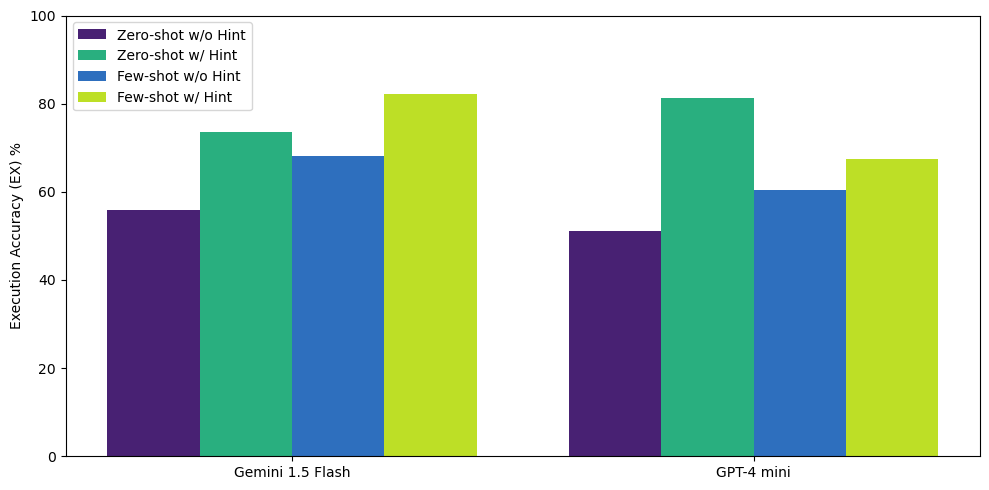

In [13]:
models = ['Gemini 1.5 Flash', 'GPT-4 mini']
conditions = ['Zero-shot w/o Hint', 'Zero-shot w/ Hint', 'Few-shot w/o Hint', 'Few-shot w/ Hint']

data = np.array([
    [df.loc[0, 'EX_by_diff_total'], df.loc[2, 'EX_by_diff_total'], df.loc[4, 'EX_by_diff_total'], df.loc[6, 'EX_by_diff_total']],  # Gemini
    [df.loc[1, 'EX_by_diff_total'], df.loc[3, 'EX_by_diff_total'], df.loc[5, 'EX_by_diff_total'], df.loc[7, 'EX_by_diff_total']],  # GPT-4 mini
])

colors = ['#482173', '#29af7f', '#2e6fbe', '#bddf26']

# Configuración del gráfico
fig, ax = plt.subplots(figsize=(10, 5))

# Ancho de las barras y posiciones
bar_width = 0.2  # Hacer las barras más estrechas para que quepan mejor
index = np.arange(len(models))  # Indices para las etiquetas en el eje x

for i in range(len(conditions)):
    ax.bar(index + i * bar_width - bar_width /2, data[:, i], bar_width, label=conditions[i], color=colors[i % len(colors)])  # Utilizar el operador módulo para asegurarse de que el índice esté dentro del rango


# Añadir anotaciones de porcentaje encima de las barras
#for i in range(len(conditions)):
#    for j in range(len(models)):
#        ax.annotate(f"{data[j, i]:.2f}%", 
#                    (index[j] + i * bar_width - bar_width / 2, data[j, i] + 1), 
#                    ha='center', va='bottom', fontsize=9)

# Configuración de etiquetas y leyenda
ax.set_ylabel('Execution Accuracy (EX) %')
#ax.set_title('Execution Accuracy by Model and Condition')
#ax.set_xticks(index)  # Centrar etiquetas de modelos
ax.set_xticks(index + bar_width) # * (len(conditions) - 1) / 2)  # Centrar etiquetas de modelos
ax.set_xticklabels(models)

# Añadir leyenda
ax.legend(loc='upper left')

# Ajustar el límite del eje y
ax.set_ylim(0, 100)

# Ajustar los márgenes para que el gráfico no se corte
plt.tight_layout()

plt.savefig('imagen/ex_total.png', dpi=300, bbox_inches='tight')
# Mostrar el gráfico
plt.show()


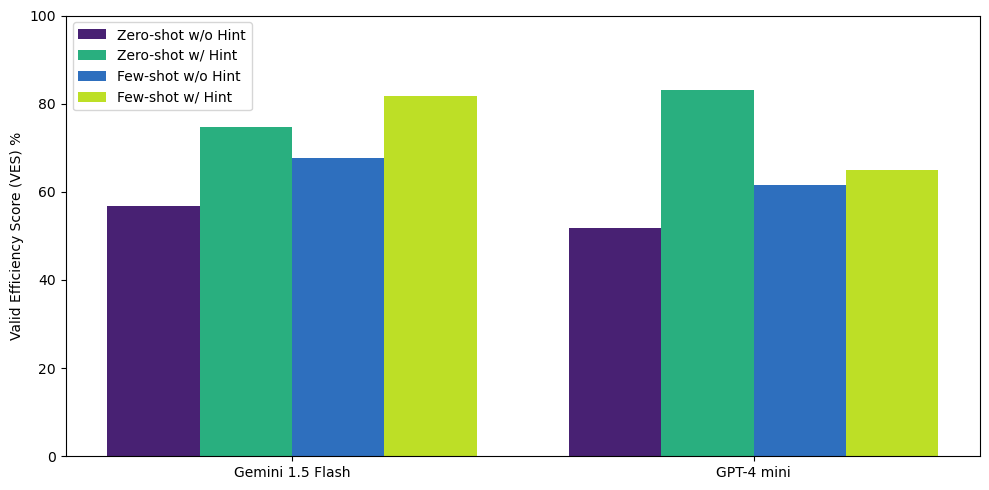

In [14]:
models = ['Gemini 1.5 Flash', 'GPT-4 mini']
conditions = ['Zero-shot w/o Hint', 'Zero-shot w/ Hint', 'Few-shot w/o Hint', 'Few-shot w/ Hint']

data = np.array([
    [df.loc[0, 'VES'], df.loc[2, 'VES'], df.loc[4, 'VES'], df.loc[6, 'VES']],  # Gemini
    [df.loc[1, 'VES'], df.loc[3, 'VES'], df.loc[5, 'VES'], df.loc[7, 'VES']],  # GPT-4 mini
])

colors = ['#482173', '#29af7f', '#2e6fbe', '#bddf26']

# Configuración del gráfico
fig, ax = plt.subplots(figsize=(10, 5))

# Ancho de las barras y posiciones
bar_width = 0.2  # Hacer las barras más estrechas para que quepan mejor
index = np.arange(len(models))  # Indices para las etiquetas en el eje x

for i in range(len(conditions)):
    ax.bar(index + i * bar_width - bar_width /2, data[:, i], bar_width, label=conditions[i], color=colors[i % len(colors)])  # Utilizar el operador módulo para asegurarse de que el índice esté dentro del rango


# Añadir anotaciones de porcentaje encima de las barras
#for i in range(len(conditions)):
#    for j in range(len(models)):
#        ax.annotate(f"{data[j, i]:.2f}%", 
#                    (index[j] + i * bar_width - bar_width / 2, data[j, i] + 1), 
#                    ha='center', va='bottom', fontsize=9)

# Configuración de etiquetas y leyenda
ax.set_ylabel('Valid Efficiency Score (VES) %')
#ax.set_title('Execution Accuracy by Model and Condition')
#ax.set_xticks(index)  # Centrar etiquetas de modelos
ax.set_xticks(index + bar_width) # * (len(conditions) - 1) / 2)  # Centrar etiquetas de modelos
ax.set_xticklabels(models)

# Añadir leyenda
ax.legend(loc='upper left')

# Ajustar el límite del eje y
ax.set_ylim(0, 100)

# Ajustar los márgenes para que el gráfico no se corte
plt.tight_layout()

plt.savefig('imagen/ves_total.png', dpi=300, bbox_inches='tight')
# Mostrar el gráfico
plt.show()

In [16]:
few_shot

,question_id,gemini_1.5_Flash,chatgpt_4mini,ground_truth,difficulty
0,717,SELECT DISTINCT sp.power_name FROM superher...,SELECT sp.power_name FROM superpower sp JOIN h...,SELECT T3.power_name FROM superhero AS T1 INNE...,simple
1,718,SELECT COUNT(DISTINCT s.id) AS super_strength...,SELECT COUNT(DISTINCT hp.hero_id) AS total_sup...,SELECT COUNT(T1.hero_id) FROM hero_power AS T1...,simple
2,719,SELECT COUNT(DISTINCT s.id) AS num_super_stro...,SELECT COUNT(DISTINCT hp.hero_id) AS total_sup...,SELECT COUNT(T1.id) FROM superhero AS T1 INNER...,moderate
3,720,SELECT s.full_name FROM superhero s JOIN hero...,SELECT s.full_name FROM superhero s JOIN hero_...,SELECT DISTINCT T1.full_name FROM superhero AS...,simple
4,721,SELECT COUNT(DISTINCT s.id) AS blue_eyed_hero...,SELECT COUNT(DISTINCT s.id) AS total_blue_eyed...,SELECT COUNT(T1.id) FROM superhero AS T1 INNER...,simple
...,...,...,...,...,...
124,841,"SELECT s.weight_kg, r.race FROM superhero s J...","SELECT s.weight_kg, r.race FROM superhero s JO...","SELECT T1.weight_kg, T2.race FROM superhero AS...",simple
125,842,SELECT AVG(s.height_cm) AS average_height FRO...,"SELECT ROUND(AVG(s.height_cm), 2) AS avg_heigh...",SELECT AVG(T1.height_cm) FROM superhero AS T1 ...,simple
126,843,SELECT DISTINCT hp.hero_id FROM hero_power hp...,SELECT hp.hero_id FROM superpower sp JOIN hero...,SELECT T1.hero_id FROM hero_power AS T1 INNER ...,simple
127,844,SELECT c.colour FROM superhero s JOIN colour ...,SELECT c.colour AS eye_colour FROM superhero s...,SELECT T2.colour FROM superhero AS T1 INNER JO...,simple


In [ ]:
def execution_acc(df, model, db_path):
    ex = []
    err = []

    with sqlite3.connect(db_path) as conn:
        for _, row in df.iterrows():
            predicted_sql = row[model]
            ground_truth = row['ground_truth']

            try:
                cursor = conn.cursor()
                cursor.execute(predicted_sql, ())
                predicted_res = cursor.fetchall()
                cursor.execute(ground_truth, ())
                ground_truth_res = cursor.fetchall()
                res = 0
                if set(predicted_res) == set(ground_truth_res):
                    res = 1
            except sqlite3.Error as e:
                #print(f"An error occurred: {e}")  # Print the error if something goes wrong
                #er = str(row['question_id']) + ': ' + str(e)
                res = 0
                
                #err.append(er)
            ex.append(res)

    #print(f'Execution Accuracy: {sum(ex) / len(ex) * 100:.2f} %')

    return ex #, err

# PROBAR

In [1]:
import sqlite3
import pandas as pd

# Función para conectar a la base de datos
def connect_to_db(db_path):
    """Conecta a una base de datos SQLite."""
    connection = sqlite3.connect(db_path)
    return connection

# Función para ejecutar consultas
def execute_query(connection, query):
    """Ejecuta una consulta SQL y devuelve los resultados."""
    try:
        cursor = connection.cursor()
        cursor.execute(query)
        return cursor.fetchall()
    except sqlite3.Error as e:
        print(f"Error executing query: {e}")
        return None

# Funciones para detectar tipos de errores
def check_shortcut_error(connection, gold_query, pred_query):
    """Compara los resultados de la gold query y la pred query para detectar errores de shortcut."""
    gold_result = execute_query(connection, gold_query)
    pred_result = execute_query(connection, pred_query)
    # Ejemplo básico: el error ocurre si el resultado predicho es incorrecto o usa valores que no están en gold query
    return gold_result != pred_result

def check_extra_columns_error(connection, gold_query, pred_query):
    """Detecta si la predicción incluye columnas adicionales en la consulta."""
    gold_result = execute_query(connection, gold_query)
    pred_result = execute_query(connection, pred_query)
    
    # Comparar longitud de los resultados, si uno tiene más columnas que el otro, es un error de columnas extra
    if gold_result and pred_result:
        return len(gold_result[0]) < len(pred_result[0])  # Suponiendo que las filas devuelven tuplas
    return False

def check_select_convention_error(connection, gold_query, pred_query):
    """Detecta si la convención de SELECT es incorrecta (ej: uso de DISTINCT incorrecto)."""
    gold_result = execute_query(connection, gold_query)
    pred_result = execute_query(connection, pred_query)
    
    # Ejemplo: verificar si se usa DISTINCT incorrectamente
    gold_has_distinct = "DISTINCT" in gold_query.upper()
    pred_has_distinct = "DISTINCT" in pred_query.upper()
    
    return gold_has_distinct != pred_has_distinct

# Cargar DataFrame con las consultas
data = {
    'Gold': [
        "SELECT count(*) FROM CAR_MAKERS AS T1 JOIN MODEL_LIST AS T2 ON T1.Id = T2.Maker WHERE T1.FullName = 'American Motor Company';", 
        "SELECT City, Country FROM AIRPORTS WHERE AirportName = 'Alton';", 
        "SELECT Name FROM conductor ORDER BY Year_of_Work DESC;", 
        "SELECT Maker, Model FROM MODEL_LIST;"
    ],
    'Pred': [
        "SELECT COUNT(Model) FROM model_list WHERE Maker = 1;", 
        "SELECT City, Country FROM airports WHERE AirportCode = 'ALN';", 
        "SELECT Name, Year_of_Work FROM conductor ORDER BY Year_of_Work DESC;", 
        "SELECT DISTINCT car_makers.Maker, model_list.Model FROM car_makers JOIN model_list ON car_makers.Id = model_list.Maker;"
    ]
}

df = pd.DataFrame(data)

# Conectar a la base de datos
db_path = 'your_database.db'  # Ruta a tu base de datos SQLite o el string de conexión de otra BD
connection = connect_to_db(db_path)

# Aplicar las funciones de evaluación
df['Shortcut_Error'] = df.apply(lambda row: check_shortcut_error(connection, row['Gold'], row['Pred']), axis=1)
df['Extra_Columns_Error'] = df.apply(lambda row: check_extra_columns_error(connection, row['Gold'], row['Pred']), axis=1)
df['Select_Convention_Error'] = df.apply(lambda row: check_select_convention_error(connection, row['Gold'], row['Pred']), axis=1)

# Cerrar la conexión a la base de datos
connection.close()

# Mostrar el DataFrame con los errores categorizados
print(df)

# Contabilizar el porcentaje de cada tipo de error
total_predictions = len(df)
shortcut_error_pct = df['Shortcut_Error'].sum() / total_predictions * 100
extra_columns_error_pct = df['Extra_Columns_Error'].sum() / total_predictions * 100
select_convention_error_pct = df['Select_Convention_Error'].sum() / total_predictions * 100

print(f"Shortcut Errors: {shortcut_error_pct:.2f}%")
print(f"SELECT Extra Columns Errors: {extra_columns_error_pct:.2f}%")
print(f"SELECT Convention Errors: {select_convention_error_pct:.2f}%")


Error executing query: no such table: CAR_MAKERS
Error executing query: no such table: model_list
Error executing query: no such table: AIRPORTS
Error executing query: no such table: airports
Error executing query: no such table: conductor
Error executing query: no such table: conductor
Error executing query: no such table: MODEL_LIST
Error executing query: no such table: car_makers
Error executing query: no such table: CAR_MAKERS
Error executing query: no such table: model_list
Error executing query: no such table: AIRPORTS
Error executing query: no such table: airports
Error executing query: no such table: conductor
Error executing query: no such table: conductor
Error executing query: no such table: MODEL_LIST
Error executing query: no such table: car_makers
Error executing query: no such table: CAR_MAKERS
Error executing query: no such table: model_list
Error executing query: no such table: AIRPORTS
Error executing query: no such table: airports
Error executing query: no such table